# The inelastic Xe spectrum

Tunnell and Aalbers, Feburary 2016

This tutorial shows how to use isolate the gamma emission peaks from inelastic neutron absorption by Xe triggered by an AmBe source. You'll learn how to apply basic data quality and range-of-interest selection cuts.

In [1]:
# Boilerplate startup code
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
matplotlib.rc('font', size=16)                   # Use big fonts...
plt.rcParams['figure.figsize'] = (12.0, 10.0)    # ... and big plots

# Import the XENON100 configuration from pax
from pax.configuration import load_configuration
pax_config = load_configuration('XENON100')

import hax
# In case you have your a custom path to the data, set it here (see the tutorial)
# (hopefully we set things up for the workshop so you don't have to)
hax.init(experiment='XENON100')

/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


# Table of Contents
 <p><div class="lev1"><a href="#The-inelastic-Xe-spectrum-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The inelastic Xe spectrum</a></div><div class="lev2"><a href="#Background-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Background</a></div><div class="lev1"><a href="#Data-selection-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data selection</a></div><div class="lev1"><a href="#Data-cleaning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data cleaning</a></div><div class="lev2"><a href="#Sanity-cut-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Sanity cut</a></div><div class="lev2"><a href="#Fiducial-volume-and-spatial-corrections-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Fiducial volume and spatial corrections</a></div><div class="lev2"><a href="#Double-scatters-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Double scatters</a></div><div class="lev1"><a href="#Fitting-the-peaks-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fitting the peaks</a></div><div class="lev2"><a href="#Selecting-only-the-Xe-peaks-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Selecting only the Xe peaks</a></div><div class="lev2"><a href="#Method-1-:-Gaussian-mixture-model-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Method 1 : Gaussian mixture model</a></div><div class="lev2"><a href="#Method-2:-Slice-out-one-peak-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Method 2: Slice out one peak</a></div><div class="lev2"><a href="#Method-3:-1d-reduction-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Method 3: 1d reduction</a></div><div class="lev1"><a href="#Appendix:-position-plots-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Appendix: position plots</a></div>

## Background

When a neutron hits a xenon nucleus, it can excite it to an unstable state, which relaxes by emission of a gamma ray. Since these gamma rays are of a known energy, they can be used to calibrate the absolute light and charge detection efficiency of the detector. Unlike a Cs137 photopeak (662 keV), these gamma rays have relatively low energies (down to 40 keV), which makes them more relevant for dark matter searches. 

For more background, see these notes:

 * https://xecluster.lngs.infn.it/dokuwiki/doku.php?id=xenon:xenon1t:analysis_run12:ces_ambe_1
 * https://xecluster.lngs.infn.it/dokuwiki/doku.php?id=mcfate:globalenergyscale

# Data selection

In the tutorial you saw that minitrees provide you with most of the information you need for basic analyses. You also saw how to select datasets. Let's put these two together, and load the minitrees for all AmBe run10 datasets (... at least those we managed to process before the workshop!)

In [2]:
query = 'source == "AmBe" & category == "standard" & tpc == "xenon100" & location != ""'
datasets_ambe = hax.runs.datasets_query(query)
df = hax.minitrees.load(datasets_ambe)

Created minitree Basics for dataset xe100_110210_1100
Created minitree Basics for dataset xe100_110210_1412


Created minitree Basics for dataset xe100_110211_0532
Found minitree at ./xe100_120404_0804_Basics.root


# Data cleaning

Before we can fit anything, we should clean the data of undesireable events and applying corrections to ensure the detector response is homogeneous. We will take you through some basic, physically motivated cuts. 

(Don't let all the plots and discussion confuse you by the way: these cuts can be applied in a few lines, once you know how!)

## Sanity cut

Before proceeding any further, it's worth cutting out events that don't even have an interaction (S1+S2 pair), for example by requiring cs1 > 0 (if you don't remember what cs1 is, see [the Basics minitree documentation](http://hax.readthedocs.org/en/latest/hax.treemakers.html#module-hax.treemakers.Basics)).

Pandas (and numpy) have a very easy way to do cuts like this. If you do:

    df['cs1'] > 0 
    
you'll get a long list (actually, a pandas Series) of booleans, True if the condition is met, False if it is not. This you can pass as a slice to the dataframe:

    df[ df['cs1'] > 0 ]

then you'll get back a new dataframe with just the events that pass the selection! Indeed, this reduces the number of events quite a bit:

In [3]:
len(df[ df['cs1'] > 0 ]) / len(df)

0.3677478564991277

While we could simply do:
    
    df = df[ df['cs1] > 0 ]
    
to apply the cut, it's more convenient to define a mini-function which applies the cut for us, and also print out how many events were accepted and rejected. We can re-use this later when we do more complex selections.

In [4]:
def do_cut(cut, name=''):
    """Does a cut (specified as boolean array or Series) on df, modifying it in place.
    Additionally, prints out passthrough info
    """
    global df    # This lets us modify df, which lives outside the function
    n_before = len(df)
    df = df[cut]
    print("%s cut: %d events removed (%0.2f%% passthrough)" % (
            name, n_before - len(df), len(df)/n_before * 100))

do_cut(df['cs1'] > 0, 'At least an interaction')

At least an interaction cut: 76469 events removed (36.77% passthrough)


Notice that if you run this cell a second time, the cut won't remove any more events (since it is already applied). If you'd like to start from scratch with a fresh dataframe, just just reload the dataframe from the minitrees (execute the cell with hax.minitrees.load above).

If you don't like this, you can also give a new name to the cut dataframe, like this:

    df_cut = df[ df['cs1'] > 0 ]

## Fiducial volume and spatial corrections

Let's have a look at the events in our data. For example, let's show the S1 vs S2 scatter plot, with z position on the color axis:

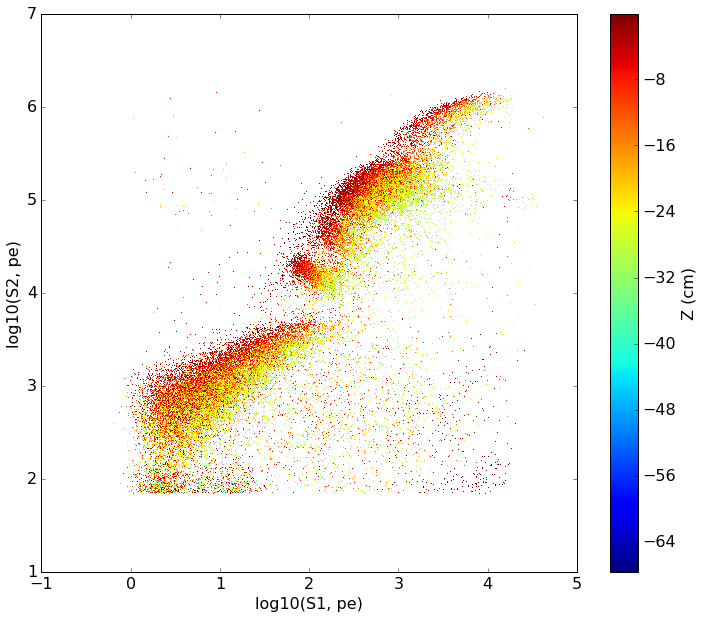

In [5]:
plt.scatter(np.log10(df['s1']), np.log10(df['s2']), c=df['z'], 
            marker=',', edgecolors='none', s=1)
plt.colorbar(label='Z (cm)')
plt.xlabel('log10(S1, pe)')
plt.ylabel('log10(S2, pe)')
plt.show()

We can identify two problems, both related to the fact that our detector has extension in space:
  * The spectral "lines" (blobs, rather) are smeared out, with shallow events (z closer to 0) showing a larger S2 but smaller S1. This is because **we used s1 and s2 rather than their corrected cousins**: cs1 (which adjust for the position-dependent light-yield) and cs2 (which adjusts for the position-dependent charge yield, chiefly caused by electron lifetime, i.e. impurities).
  * There are a few events with impossible drift times (longer than the TPC!). Fortunately these are rare:

In [6]:
tpc_length = pax_config['DEFAULT']['tpc_length']
tpc_radius = pax_config['DEFAULT']['tpc_radius']

weird_events = df[df['z'] < -tpc_length]
print("%0.2f %% of events have impossible drift times" % (100 * len(weird_events)/len(df)))

1.36 % of events have impossible drift times


Here we will simply remove them by applying a light "fiducial volume cut":

In [7]:
do_cut((-0.05 * tpc_length > df['z']) & (df['z'] > - 0.95 * tpc_length), 'z')

z cut: 5563 events removed (87.49% passthrough)


In [8]:
do_cut((df['x']**2 + df['y']**2)**0.5 < tpc_radius * 0.95, 'radial')

radial cut: 2657 events removed (93.17% passthrough)


Together with using the corrected quantities, as we should have from the beginning, this cleans up the spectrum quite a bit:

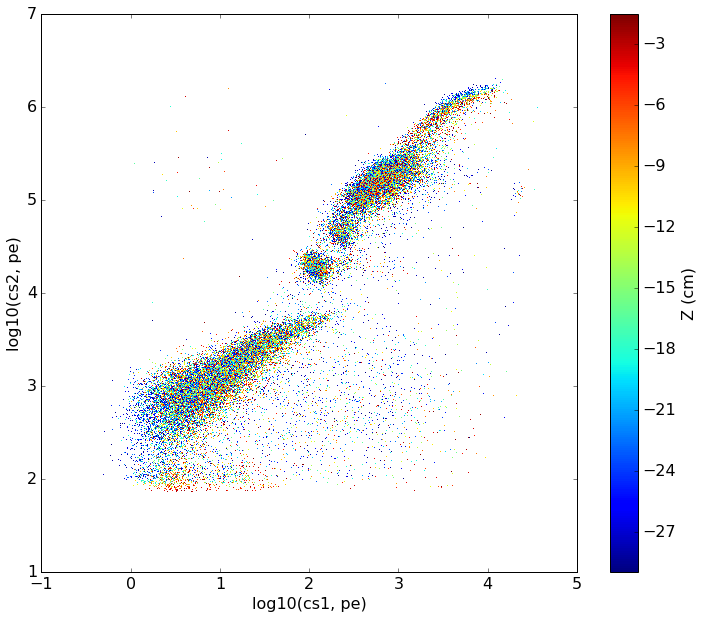

In [9]:
plt.scatter(np.log10(df['cs1']), np.log10(df['cs2']), c=df['z'], 
            marker=',', edgecolors='none', s=1)
plt.colorbar(label='Z (cm)')
plt.xlabel('log10(cs1, pe)')
plt.ylabel('log10(cs2, pe)')
plt.show()

From the colors you see there does not appear to be a significant z-smearing anymore... except at very high-energy (probably due to PMT saturation: can you make a treemaker to load the relevant variable to check this?)

## Double scatters

Another pathology to check for are double scatter events. These usually show up as events with one unusually large S1, then multiple S2s. The basics minitree contains a variable largest_other_s2 containing, as you might have guessed, the (uncorrected) area of the largest S2 that is not part of the main interaction. Let's change the color scale from z to log10(largest_other_s2) to make these events visible:

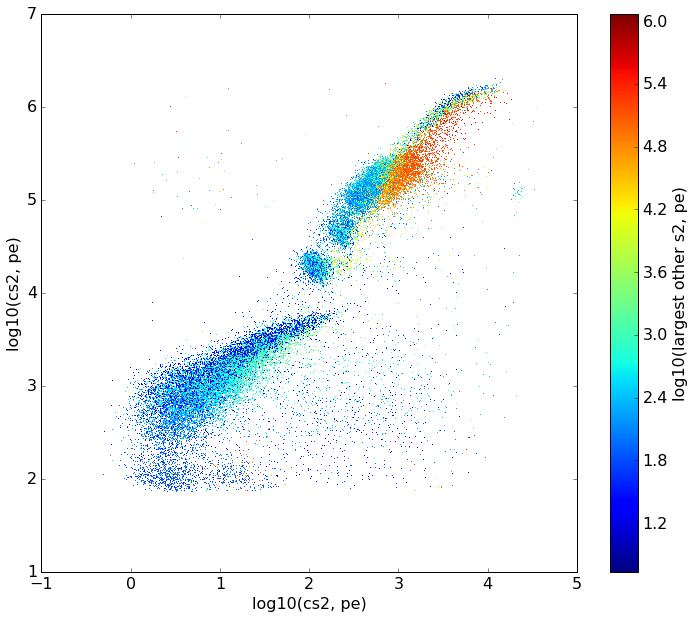

In [10]:
plt.scatter(np.log10(df['cs1']), np.log10(df['cs2']), 
            c=np.log10(df['largest_other_s2']), 
            marker=',', edgecolors='none', s=1)
plt.colorbar(label='log10(largest other s2, pe)')
plt.xlabel('log10(cs2, pe)')
plt.ylabel('log10(cs2, pe)')
plt.show()

Some questions for you:

 * Why do we not give the corrected area of largest_other_s2? 
 * In the low-S2 region you can see some events with largest_other_s2 larger than the main s2. How is this possible?

In [11]:
do_cut(df['largest_other_s2'] < 2000, 'Double scatter (absolute)')
do_cut(df['largest_other_s2'] < 0.5 * df['cs2'], 'Double scatter (relative)')

Double scatter (absolute) cut: 6334 events removed (82.53% passthrough)
Double scatter (relative) cut: 4701 events removed (84.29% passthrough)


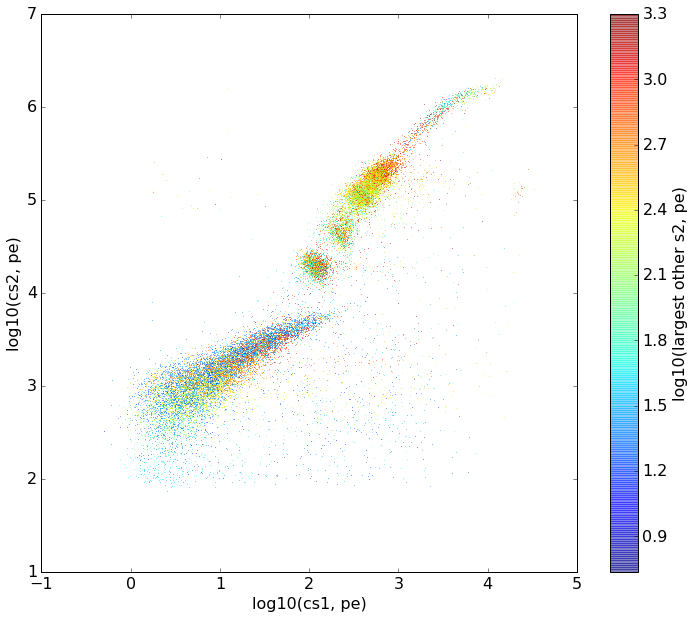

In [12]:
plt.scatter(np.log10(df['cs1']), np.log10(df['cs2']), 
            c=np.log10(df['largest_other_s2']), 
            marker=',', edgecolors='none', s=1, alpha=0.5)
plt.colorbar(label='log10(largest other s2, pe)')
plt.xlabel('log10(cs1, pe)')
plt.ylabel('log10(cs2, pe)')
plt.show()

# Fitting the peaks

While there are much more pathologies we could look for, we can clearly see some of the monoenergetic features we want to fit, so let's go for it!

## Selecting only the Xe peaks

First, let's select a box containing just the AmBe lines we are interested in, throwing away the elastic nuclear recoil band (at low energy) and some high energy stuff (what are those?).

We'll switch from a scatter plot to a histogram to enable you to visualize the density more clearly.

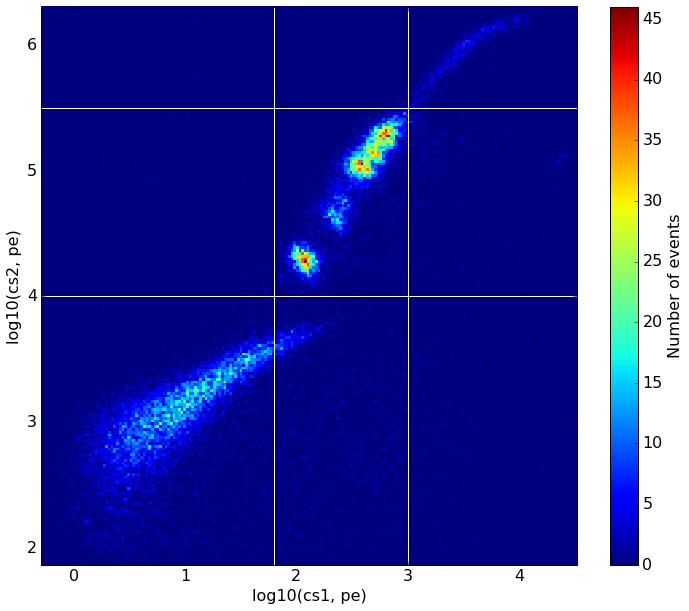

In [13]:
plt.hist2d(np.log10(df['cs1']), np.log10(df['cs2']), 
           bins=200)
plt.colorbar(label='Number of events')
plt.xlabel('log10(cs1, pe)')
plt.ylabel('log10(cs2, pe)')

plt.axvline(1.8 , color='white')
plt.axvline(3 , color='white')
plt.axhline(4, color='white')
plt.axhline(5.5, color='white')
plt.show()

In [14]:
do_cut((np.log10(df['cs1']) > 1.8) & 
       (np.log10(df['cs1']) < 3) & 
       (np.log10(df['cs2']) > 4) & 
       (np.log10(df['cs2']) < 5.5), name='Energy range')

Energy range cut: 15702 events removed (37.75% passthrough)


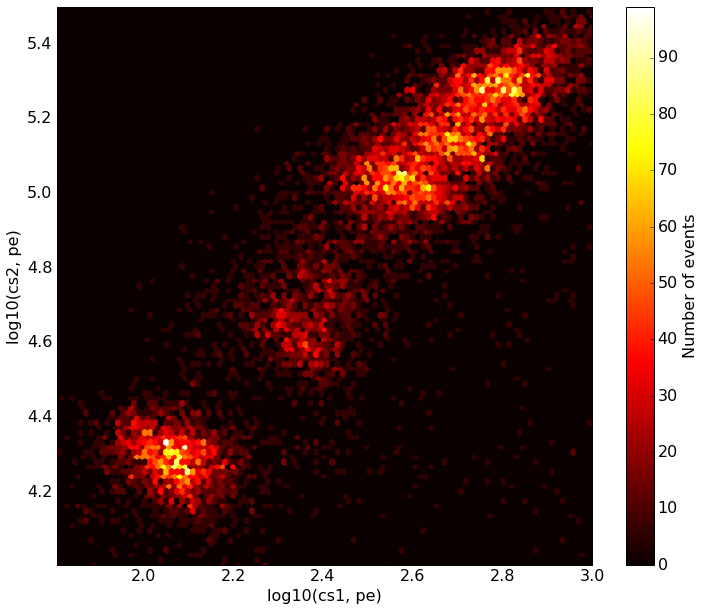

In [15]:
plt.hexbin(np.log10(df['cs1']), np.log10(df['cs2']), 
           bins=100, cmap=plt.cm.hot)
plt.colorbar(label='Number of events')
plt.xlabel('log10(cs1, pe)')
plt.ylabel('log10(cs2, pe)')

Some of these events are from activated F instead of Xe, which is concentrated at the edge (F is in the tpc walls, hopefully not in the Xe itself!). We can fit the F and Xe peaks separately by selecting high/low radius events. Here we will just select the Xe events, by applying a stricter radial cut:

In [16]:
do_cut((df['x']**2 + df['y']**2)**0.5 < tpc_radius * 0.8, 'radial')

radial cut: 5867 events removed (38.38% passthrough)


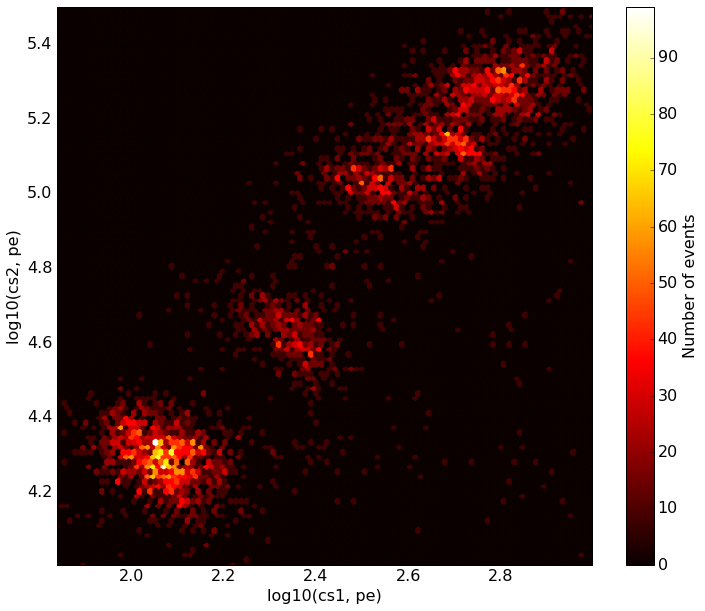

In [17]:
plt.hexbin(np.log10(df['cs1']), np.log10(df['cs2']), 
           bins=100, cmap=plt.cm.hot)
plt.colorbar(label='Number of events')
plt.xlabel('log10(cs1, pe)')
plt.ylabel('log10(cs2, pe)')

Unfortunately this also reduces the number of events quite a bit, since AmBe is on the outside... you can't win them all.

## Method 1 : Gaussian mixture model

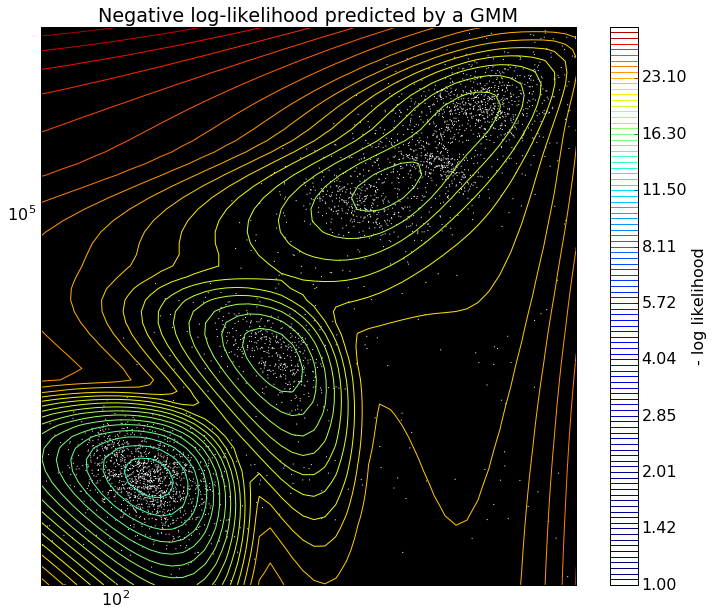

In [18]:
from sklearn import mixture

# Form an S1, S2 dataset
xdata = df['cs1'].values
ydata = df['cs2'].values
twod_data = np.dstack((xdata, ydata))[0]

# Fit a Gaussian Mixture Model
clf = mixture.GMM(n_components=6, covariance_type='full')
clf.fit(twod_data)

# Determine plot points
x = np.logspace(np.log10(df['cs1'].min()), np.log10(df['cs1'].max()))
y = np.logspace(np.log10(df['cs2'].min()), np.log10(df['cs2'].max()))

# Display likelihood predicted by the model as a contour plot
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)[0]
Z = Z.reshape(X.shape)
CS = plt.contour(X, Y, Z, 
                 levels=np.logspace(0, 1.5, 100))
                 #norm=matplotlib.colors.LogNorm(vmin=1, vmax=100))
CB = plt.colorbar(CS, extend='both', label='- log likelihood')

# Plot the real data on top
plt.scatter(xdata, ydata,
            color='white', s=5, marker='.', edgecolors='none')

plt.gca().set_axis_bgcolor('black')            
plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.ylim((y.min(), y.max()))
plt.xlim((x.min(), x.max()))
plt.xscale('log')
plt.yscale('log')
plt.show()

Works for the first two peaks, not so well for the others.
TODO: 
 * difficult to judge plot because using - log likelihood..
 * plot means, major & minor axes

## Method 2: Slice out one peak

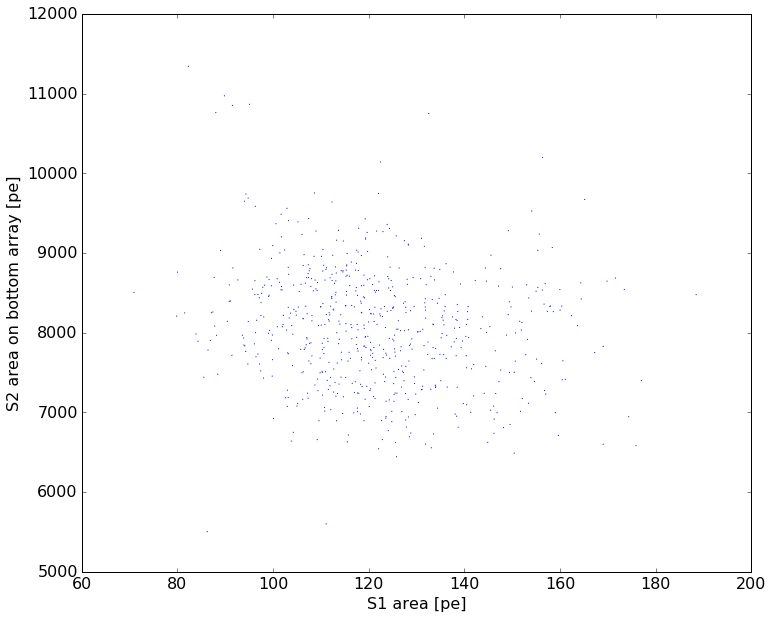

In [19]:
df_40kev = df[(df['cs1'] > 50) & (df['cs1'] < 200) & (df['cs2'] > 15000) & (df['cs2'] < 20000)]

plt.scatter(df_40kev['cs1'],
            df_40kev['cs2'] * (1 - df_40kev['s2_area_fraction_top']),
            marker='.',
            s=5,
            alpha=1.0,
            edgecolors='none')

plt.xlabel('S1 area [pe]')
plt.ylabel('S2 area on bottom array [pe]')

plt.show()

In [20]:
print('S1 (40 keV) pe:', df_40kev['cs1'].mean(), '+/-', df_40kev['cs1'].std())
print('S2 (40 keV) pe:', df_40kev['cs2'].mean(), '+/-', df_40kev['cs2'].std())

S1 (40 keV) pe: 121.54723809 +/- 18.4811072083
S2 (40 keV) pe: 17873.5153382 +/- 1351.8679172


In [21]:
print('S1 pe/keV:', df_40kev['cs1'].mean()/40)
print('S2 pe/keV:', df_40kev['cs2'].mean()/40)

S1 pe/keV: 3.03868095225
S2 pe/keV: 446.837883455


## Method 3: 1d reduction

Exercise: try to
    
 * Fit a straight line through the data to derive a (very very rough) combined energy scale
 * Make a 1d histogram of events vs energy
 * Try to fit the resulting peaks and extract a light and charge yield for each.

# Appendix: position plots

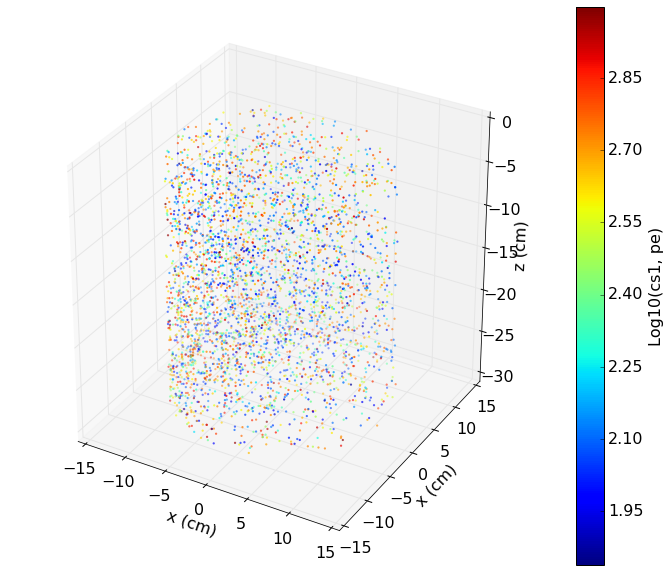

In [22]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(df['x'], df['y'], df['z'], c=np.log10(df['cs1']),
               zdir='z', s=20, marker='.', edgecolors='none',
               depthshade=True)

ax.set_zlim(0, -tpc_length)
ax.set_zlabel('z (cm)')
ax.invert_zaxis()

r = pax_config['DEFAULT']['tpc_radius']
ax.set_xlim(-tpc_radius, tpc_radius)
ax.set_xlabel('x (cm)')

ax.set_ylabel('x (cm)')
ax.set_ylim(-tpc_radius, tpc_radius)

plt.colorbar(p, label='Log10(cs1, pe)')
plt.show()

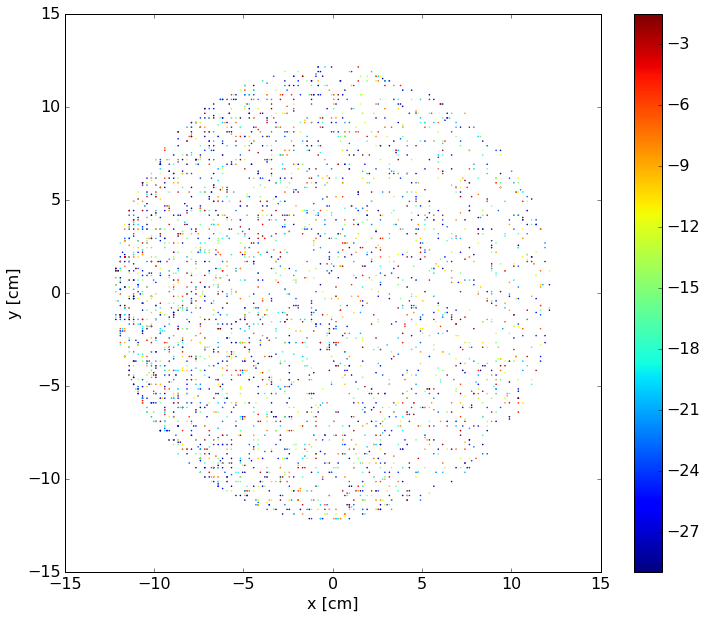

In [23]:
plt.scatter(df['x'],df['y'], c=df['z'], marker='.', s=10, edgecolors='none')
plt.colorbar()
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.show()